In [ ]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [ ]:
# Check the GPU type

!nvidia-smi

Wed Jun 11 22:27:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Imports

from contextlib import contextmanager
from copy import deepcopy
import math

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange


In [ ]:
# Utilities

@contextmanager
def train_mode(model, mode=True):
    """A context manager that places a model into training mode and restores
    the previous mode on exit."""
    modes = [module.training for module in model.modules()]
    try:
        yield model.train(mode)
    finally:
        for i, module in enumerate(model.modules()):
            module.training = modes[i]


def eval_mode(model):
    """A context manager that places a model into evaluation mode and restores
    the previous mode on exit."""
    return train_mode(model, False)


@torch.no_grad()
def ema_update(model, averaged_model, decay):
    """Incorporates updated model parameters into an exponential moving averaged
    version of a model. It should be called after each optimizer step."""
    model_params = dict(model.named_parameters())
    averaged_params = dict(averaged_model.named_parameters())
    assert model_params.keys() == averaged_params.keys()

    for name, param in model_params.items():
        averaged_params[name].mul_(decay).add_(param, alpha=1 - decay)

    model_buffers = dict(model.named_buffers())
    averaged_buffers = dict(averaged_model.named_buffers())
    assert model_buffers.keys() == averaged_buffers.keys()

    for name, buf in model_buffers.items():
        averaged_buffers[name].copy_(buf)


In [ ]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, dropout_last=True):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if dropout_last else nn.Identity(),
            nn.ReLU(inplace=True),
        ], skip)


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])


class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        # The inputs to timestep_embed will approximately fall into the range
        # -10 to 10, so use std 0.2 for the Fourier Features.
        self.timestep_embed = FourierFeatures(1, 16, std=0.2)
        self.class_embed = nn.Embedding(10, 4)

        self.net = nn.Sequential(   # 32x32
            ResConvBlock(1 + 16 + 4, c, c),
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),  # 32x32 -> 16x16
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),  # 16x16 -> 8x8
                    ResConvBlock(c * 2, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),  # 8x8 -> 4x4
                        ResConvBlock(c * 4, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        nn.Upsample(scale_factor=2),
                    ]),  # 4x4 -> 8x8
                    ResConvBlock(c * 8, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    nn.Upsample(scale_factor=2),
                ]),  # 8x8 -> 16x16
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2),
            ]),  # 16x16 -> 32x32
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 1, dropout_last=False),
        )

    def forward(self, input, log_snrs, cond):
        timestep_embed = expand_to_planes(self.timestep_embed(log_snrs[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond), input.shape)
        return self.net(torch.cat([input, class_embed, timestep_embed], dim=1))


In [ ]:
def get_alphas_sigmas(log_snrs):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given the log SNR for a timestep."""
    return log_snrs.sigmoid().sqrt(), log_snrs.neg().sigmoid().sqrt()


def get_ddpm_schedule(t):
    """Returns log SNRs for the noise schedule from the DDPM paper."""
    return -torch.special.expm1(1e-4 + 10 * t**2).log()


@torch.no_grad()
def sample(model, x, steps, eta, classes, cutoff):
    """
    Draws samples from a model given starting noise, with optional frequency masking.
    """
    ts = x.new_ones([x.shape[0]])

    t = torch.linspace(1, 0, steps + 1)[:-1]
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)

    for i in trange(steps):
        with torch.cuda.amp.autocast():
            v = model(x, ts * log_snrs[i], classes).float()

        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        if i < steps - 1:
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                         (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            x = pred * alphas[i + 1] + eps * adjusted_sigma

            if eta > 0:
                noise = torch.randn_like(x)

                # High-pass masking (frequency domain)
                noise_fft = torch.fft.fft2(noise, norm='ortho')
                B, C, H, W = noise.shape
                mask = torch.ones((H, W), device=noise.device)
                mask[:cutoff, :cutoff] = 0

                mask = mask[None, None, :, :].expand_as(noise_fft)
                filtered_fft = noise_fft * mask
                noise = torch.fft.ifft2(filtered_fft, norm='ortho').real

                x += noise * ddim_sigma

    return pred



In [ ]:
from torchvision.datasets import MNIST

batch_size = 100

tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

train_set = datasets.MNIST('data', train=True, download=True, transform=tf)
val_set = datasets.MNIST('data', train=False, download=True, transform=tf)

train_dl = data.DataLoader(train_set, batch_size, shuffle=True,
                           num_workers=2, persistent_workers=True, pin_memory=True)
val_dl = data.DataLoader(val_set, batch_size,
                         num_workers=2, persistent_workers=True, pin_memory=True)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.13MB/s]


In [ ]:
# Create the model and optimizer



seed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)

model = Diffusion().to(device)
model_ema = deepcopy(model)
print('Model parameters:', sum(p.numel() for p in model.parameters()))

opt = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()
epoch = 0

# Use a low discrepancy quasi-random sequence to sample uniformly distributed
# timesteps. This considerably reduces the between-batch variance of the loss.
rng = torch.quasirandom.SobolEngine(1, scramble=True)

Using device: cuda
Model parameters: 23208753


<ipython-input-6-2911997451>:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


[Mask shape] torch.Size([32, 32])
[Mask stats] mean=0.5273, std=0.4995


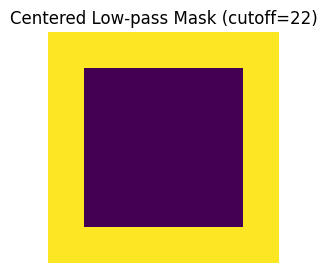

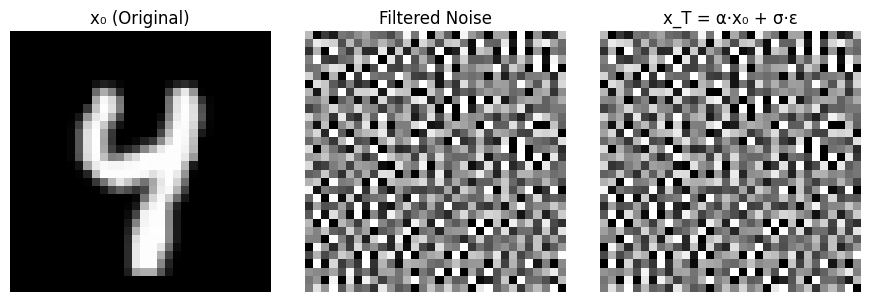

In [ ]:
import matplotlib.pyplot as plt

Cutoff_Param = 22

def debug_lowpass_mask_and_forward(reals, cutoff):
    reals = reals.to(device)
    B, C, H, W = reals.shape
    assert C == 1

    mask = torch.zeros(H, W, device=reals.device)
    cy, cx = H // 2, W // 2
    mask[:] = 1.0
    mask[cy - cutoff//2 : cy + cutoff//2, cx - cutoff//2 : cx + cutoff//2] = 0.0

    print(f"[Mask shape] {mask.shape}")
    print(f"[Mask stats] mean={mask.mean().item():.4f}, std={mask.std().item():.4f}")

    plt.figure(figsize=(3, 3))
    plt.imshow(mask.detach().cpu(), cmap='viridis')
    plt.title(f"Centered Low-pass Mask (cutoff={cutoff})")
    plt.axis('off')
    plt.show()

    x0 = reals[0:1]
    noise = torch.randn_like(x0)
    noise_fft = torch.fft.fft2(noise, norm='ortho')
    noise_fft = torch.fft.fftshift(noise_fft)

    mask_exp = mask[None, None, :, :].expand_as(noise_fft)
    filtered_fft = noise_fft * mask_exp

    filtered_fft = torch.fft.ifftshift(filtered_fft)
    filtered_noise = torch.fft.ifft2(filtered_fft, norm='ortho').real

    # Forward step: x_T = α x₀ + σ ε
    logsnr = get_ddpm_schedule(torch.tensor([1.0], device=device))
    alpha, sigma = get_alphas_sigmas(logsnr)
    xt = alpha * x0 + sigma * filtered_noise

    def to_img(x): return (x.clamp(-1, 1) + 1) / 2

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(to_img(x0[0]).squeeze().cpu(), cmap='gray')
    axs[0].set_title("x₀ (Original)")
    axs[1].imshow(to_img(filtered_noise[0]).squeeze().cpu(), cmap='gray')
    axs[1].set_title("Filtered Noise")
    axs[2].imshow(to_img(xt[0]).squeeze().cpu(), cmap='gray')
    axs[2].set_title("x_T = α·x₀ + σ·ε")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
x_batch, _ = next(iter(train_dl))
debug_lowpass_mask_and_forward(x_batch, cutoff = Cutoff_Param)



Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-10-3098888317>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation: Epoch: 0, loss: 0.164868

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-4-1232712381>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


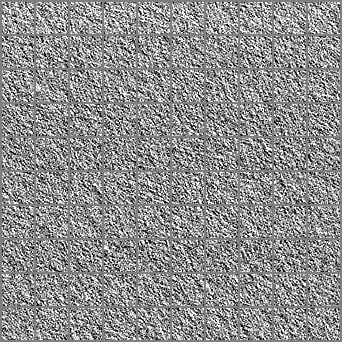


Epoch 0


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 0, iteration: 0, loss: 0.162919
Epoch: 0, iteration: 50, loss: 0.0648787
Epoch: 0, iteration: 100, loss: 0.0392998
Epoch: 0, iteration: 150, loss: 0.0302901
Epoch: 0, iteration: 200, loss: 0.0280759
Epoch: 0, iteration: 250, loss: 0.0223274
Epoch: 0, iteration: 300, loss: 0.0225713
Epoch: 0, iteration: 350, loss: 0.0205653
Epoch: 0, iteration: 400, loss: 0.0207612
Epoch: 0, iteration: 450, loss: 0.016791
Epoch: 0, iteration: 500, loss: 0.0208678
Epoch: 0, iteration: 550, loss: 0.0178636
Epoch 1


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 1, iteration: 0, loss: 0.0168369
Epoch: 1, iteration: 50, loss: 0.0152154
Epoch: 1, iteration: 100, loss: 0.0175896
Epoch: 1, iteration: 150, loss: 0.0180643
Epoch: 1, iteration: 200, loss: 0.0162584
Epoch: 1, iteration: 250, loss: 0.0157108
Epoch: 1, iteration: 300, loss: 0.0145559
Epoch: 1, iteration: 350, loss: 0.0146767
Epoch: 1, iteration: 400, loss: 0.0148605
Epoch: 1, iteration: 450, loss: 0.0147267
Epoch: 1, iteration: 500, loss: 0.0146156
Epoch: 1, iteration: 550, loss: 0.0136712

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 2, loss: 0.0119548

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

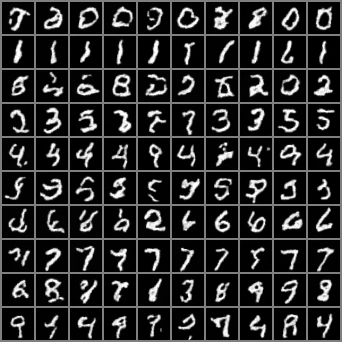


Epoch 2


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 2, iteration: 0, loss: 0.0122746
Epoch: 2, iteration: 50, loss: 0.012955
Epoch: 2, iteration: 100, loss: 0.0135093
Epoch: 2, iteration: 150, loss: 0.0129243
Epoch: 2, iteration: 200, loss: 0.0122477
Epoch: 2, iteration: 250, loss: 0.0132449
Epoch: 2, iteration: 300, loss: 0.0127964
Epoch: 2, iteration: 350, loss: 0.0129468
Epoch: 2, iteration: 400, loss: 0.0129868
Epoch: 2, iteration: 450, loss: 0.0120061
Epoch: 2, iteration: 500, loss: 0.0123319
Epoch: 2, iteration: 550, loss: 0.0128782
Epoch 3


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 3, iteration: 0, loss: 0.0125389
Epoch: 3, iteration: 50, loss: 0.0118586
Epoch: 3, iteration: 100, loss: 0.0121385
Epoch: 3, iteration: 150, loss: 0.0101202
Epoch: 3, iteration: 200, loss: 0.0125278
Epoch: 3, iteration: 250, loss: 0.0106471
Epoch: 3, iteration: 300, loss: 0.0131761
Epoch: 3, iteration: 350, loss: 0.0106434
Epoch: 3, iteration: 400, loss: 0.0117586
Epoch: 3, iteration: 450, loss: 0.011247
Epoch: 3, iteration: 500, loss: 0.0125293
Epoch: 3, iteration: 550, loss: 0.0111464

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 4, loss: 0.00990163

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

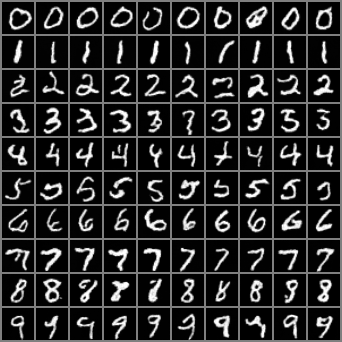


Epoch 4


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 4, iteration: 0, loss: 0.0110672
Epoch: 4, iteration: 50, loss: 0.0118051
Epoch: 4, iteration: 100, loss: 0.0114203
Epoch: 4, iteration: 150, loss: 0.011873
Epoch: 4, iteration: 200, loss: 0.0108013
Epoch: 4, iteration: 250, loss: 0.0115634
Epoch: 4, iteration: 300, loss: 0.0110718
Epoch: 4, iteration: 350, loss: 0.0103492
Epoch: 4, iteration: 400, loss: 0.0101837
Epoch: 4, iteration: 450, loss: 0.0101698
Epoch: 4, iteration: 500, loss: 0.0105392
Epoch: 4, iteration: 550, loss: 0.0114744
Epoch 5


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 5, iteration: 0, loss: 0.00983008
Epoch: 5, iteration: 50, loss: 0.0100916
Epoch: 5, iteration: 100, loss: 0.011762
Epoch: 5, iteration: 150, loss: 0.0103966
Epoch: 5, iteration: 200, loss: 0.00983117
Epoch: 5, iteration: 250, loss: 0.0113472
Epoch: 5, iteration: 300, loss: 0.0117639
Epoch: 5, iteration: 350, loss: 0.0108713
Epoch: 5, iteration: 400, loss: 0.0110538
Epoch: 5, iteration: 450, loss: 0.00981061
Epoch: 5, iteration: 500, loss: 0.0100926
Epoch: 5, iteration: 550, loss: 0.00985514

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 6, loss: 0.00912809

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

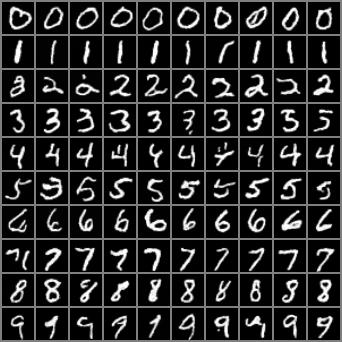


Epoch 6


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 6, iteration: 0, loss: 0.00983143
Epoch: 6, iteration: 50, loss: 0.00913913
Epoch: 6, iteration: 100, loss: 0.0116006
Epoch: 6, iteration: 150, loss: 0.0104208
Epoch: 6, iteration: 200, loss: 0.0103245
Epoch: 6, iteration: 250, loss: 0.00928528
Epoch: 6, iteration: 300, loss: 0.0102615
Epoch: 6, iteration: 350, loss: 0.00971444
Epoch: 6, iteration: 400, loss: 0.0112998
Epoch: 6, iteration: 450, loss: 0.00979569
Epoch: 6, iteration: 500, loss: 0.01041
Epoch: 6, iteration: 550, loss: 0.0106934
Epoch 7


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 7, iteration: 0, loss: 0.00977653
Epoch: 7, iteration: 50, loss: 0.0096559
Epoch: 7, iteration: 100, loss: 0.00894033
Epoch: 7, iteration: 150, loss: 0.00930496
Epoch: 7, iteration: 200, loss: 0.0100392
Epoch: 7, iteration: 250, loss: 0.00999614
Epoch: 7, iteration: 300, loss: 0.00988557
Epoch: 7, iteration: 350, loss: 0.0098671
Epoch: 7, iteration: 400, loss: 0.00960298
Epoch: 7, iteration: 450, loss: 0.00881694
Epoch: 7, iteration: 500, loss: 0.0101494
Epoch: 7, iteration: 550, loss: 0.0102369

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 8, loss: 0.00869522

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

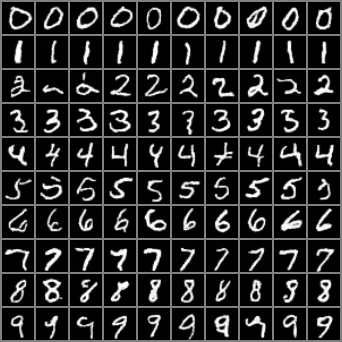


Epoch 8


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 8, iteration: 0, loss: 0.00994419
Epoch: 8, iteration: 50, loss: 0.0105146
Epoch: 8, iteration: 100, loss: 0.0104309
Epoch: 8, iteration: 150, loss: 0.00904965
Epoch: 8, iteration: 200, loss: 0.0109631
Epoch: 8, iteration: 250, loss: 0.00923096
Epoch: 8, iteration: 300, loss: 0.00917486
Epoch: 8, iteration: 350, loss: 0.00884398
Epoch: 8, iteration: 400, loss: 0.00978672
Epoch: 8, iteration: 450, loss: 0.00954843
Epoch: 8, iteration: 500, loss: 0.0101159
Epoch: 8, iteration: 550, loss: 0.00867145
Epoch 9


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 9, iteration: 0, loss: 0.00896055
Epoch: 9, iteration: 50, loss: 0.00882817
Epoch: 9, iteration: 100, loss: 0.0106134
Epoch: 9, iteration: 150, loss: 0.00905451
Epoch: 9, iteration: 200, loss: 0.00955459
Epoch: 9, iteration: 250, loss: 0.00942595
Epoch: 9, iteration: 300, loss: 0.0101493
Epoch: 9, iteration: 350, loss: 0.00984945
Epoch: 9, iteration: 400, loss: 0.00931099
Epoch: 9, iteration: 450, loss: 0.00935853
Epoch: 9, iteration: 500, loss: 0.00910607
Epoch: 9, iteration: 550, loss: 0.00930878

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 10, loss: 0.00837865

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

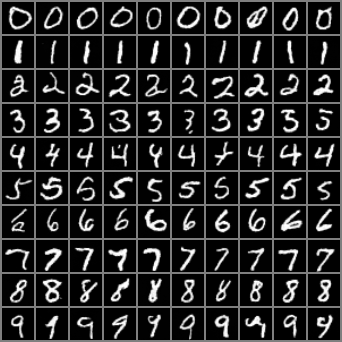

In [ ]:
# Actually train the model

ema_decay = 0.998
NUM_EPOCHS = 10

# The number of timesteps to use when sampling
steps = 500

# The amount of noise to add each timestep when sampling
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.


#Save loss
train_loss_list = []
val_loss_list = []


def eval_loss(model, rng, reals, classes, cutoff):
    t = rng.draw(reals.shape[0])[:, 0].to(device)
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)
    weights = log_snrs.exp() / log_snrs.exp().add(1)

    alphas = alphas[:, None, None, None]
    sigmas = sigmas[:, None, None, None]

    # High-pass filtering in frequency domain
    noise = torch.randn_like(reals)
    noise_fft = torch.fft.fft2(noise, norm='ortho')

    B, C, H, W = noise.shape
    mask = torch.ones(H, W, device=reals.device)
    mask[:cutoff, :cutoff] = 0.0

    mask = mask[None, None, :, :].expand_as(noise_fft)

    filtered_fft = noise_fft * mask
    filtered_noise = torch.fft.ifft2(filtered_fft, norm='ortho').real

    noised = reals * alphas + filtered_noise * sigmas
    targets = filtered_noise * alphas - reals * sigmas

    with torch.cuda.amp.autocast():
        v = model(noised, log_snrs, classes)
        return (v - targets).pow(2).mean([1, 2, 3]).mul(weights).mean()



def train():
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        loss = eval_loss(model, rng, reals, classes, cutoff = Cutoff_Param)

        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        total_loss += loss.item() * len(reals)
        count += len(reals)

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')

    avg_loss = total_loss / count
    train_loss_list.append(avg_loss)



@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def val():
    tqdm.write('\nValidating...')
    torch.manual_seed(seed)
    rng = torch.quasirandom.SobolEngine(1, scramble=True)
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(val_dl)):
        reals = reals.to(device)
        classes = classes.to(device)

        loss = eval_loss(model_ema, rng, reals, classes, cutoff=Cutoff_Param)

        total_loss += loss.item() * len(reals)
        count += len(reals)
    loss = total_loss / count
    tqdm.write(f'Validation: Epoch: {epoch}, loss: {loss:g}')
    return loss


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo():
    tqdm.write('\nSampling...')
    torch.manual_seed(seed)

    noise = torch.randn([100, 1, 32, 32], device=device)
    fakes_classes = torch.arange(10, device=device).repeat_interleave(10, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes, cutoff = Cutoff_Param)

    grid = utils.make_grid(fakes, 10).cpu()
    filename = f'demo_{epoch:05}.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    tqdm.write('')


def save():
    filename = 'cifar_diffusion.pth'
    obj = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'opt': opt.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch,
    }
    torch.save(obj, filename)


try:
    val()
    demo()
    while epoch < NUM_EPOCHS:
        print('Epoch', epoch)
        train()
        epoch += 1
        if epoch % 2 == 0:
          val_loss = val()
          val_loss_list.append(val_loss)
          demo()
        save()
except KeyboardInterrupt:
    pass


In [ ]:
@torch.no_grad()
@eval_mode(model_ema)
def generate_and_save_samples(save_path='sample_figure.png'):
    """
    Generate 64 samples from the trained diffusion model (MNIST) and save as a figure.
    """
    model_ema.eval()

    classes = torch.randint(0, 10, (64,), device=device)
    noise = torch.randn([64, 1, 32, 32], device=device)

    samples = sample(model_ema, noise, steps, eta, classes, cutoff = Cutoff_Param)
    samples = (samples.clamp(-1, 1) + 1) / 2  # [-1, 1] → [0, 1]

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            idx = i * 8 + j
            img = samples[idx].detach().cpu().squeeze().numpy()

            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-4-1232712381>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


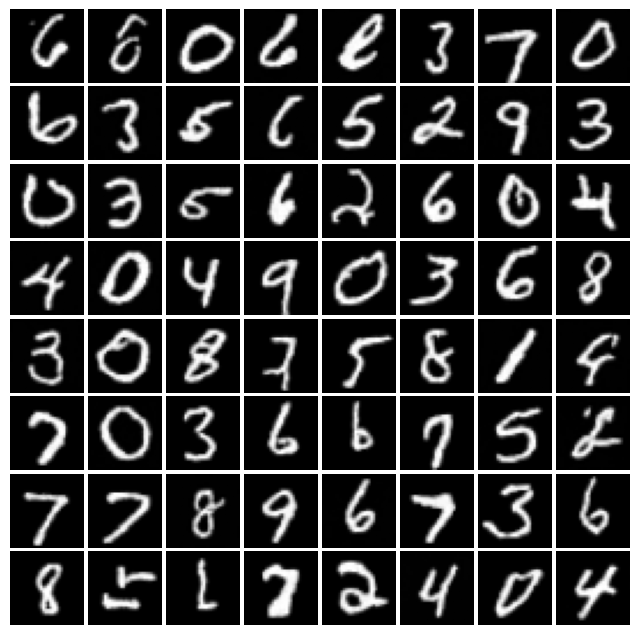

In [ ]:
generate_and_save_samples('final_samples_64.png')


FID score

In [ ]:
!pip install clean-fid


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torchvision import transforms
from cleanfid import fid
import shutil
import torch

@torch.no_grad()
@eval_mode(model_ema)
def generate_many_samples(output_dir='fid_fake_images', total=1000, batch_size=100):
    os.makedirs(output_dir, exist_ok=True)
    model_ema.eval()
    for i in range(0, total, batch_size):
        noise = torch.randn([batch_size, 1, 32, 32], device=device)  # ✅ 1채널로 수정
        classes = torch.randint(0, 10, (batch_size,), device=device)
        samples = sample(model_ema, noise, steps, eta, classes, cutoff = Cutoff_Param)
        samples = (samples.clamp(-1, 1) + 1) / 2  # [0, 1] 정규화

        for j in range(samples.size(0)):
            save_image(samples[j], os.path.join(output_dir, f"sample_{i+j:05}.png"))

def save_mnist_real_images(output_dir="fid_real_images", total=1000):
    os.makedirs(output_dir, exist_ok=True)
    dataset = MNIST(root=".", train=False, download=True, transform=transforms.ToTensor())
    for i in range(total):
        img, _ = dataset[i]
        save_image(img, f"{output_dir}/real_{i:05}.png")

# ✅ 샘플 생성 및 저장
generate_many_samples(output_dir="fid_fake_images", total=1000)
save_mnist_real_images(output_dir='fid_real_images', total=1000)

# ✅ FID 계산 (사전 통계 없이 두 폴더 직접 비교)
fid_score = fid.compute_fid("fid_fake_images", "fid_real_images")
print(f"FID score: {fid_score:.2f}")

# ✅ 정리
shutil.rmtree("fid_fake_images")
shutil.rmtree("fid_real_images")
print("Temporary folders deleted.")


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-4-1232712381>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.62MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 138kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.64MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 1000 images in the folder fid_fake_images


FID fid_fake_images : 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Found 1000 images in the folder fid_real_images


FID fid_real_images : 100%|██████████| 32/32 [00:10<00:00,  3.10it/s]


FID score: 37.63
Temporary folders deleted.


Figure generation

In [ ]:
@torch.no_grad()
@eval_mode(model_ema)
def visualize_reverse_trajectory_multi_labels(labels, total_steps=500, vis_steps=20, save_path=None):
    import matplotlib.pyplot as plt

    num_rows = len(labels)
    t = torch.linspace(1, 0, total_steps)
    log_snrs = get_ddpm_schedule(t.to(device))
    alphas, sigmas = get_alphas_sigmas(log_snrs)
    selected_idxs = torch.linspace(0, total_steps - 1, vis_steps).long().tolist()

    all_images = []

    for label in labels:
        class_label = torch.tensor([label], device=device)
        x = torch.randn(1, 1, 32, 32, device=device)

        row_images = []
        for i in range(total_steps):
            ts = log_snrs[i].expand(1)
            v = model_ema(x, ts, class_label)

            pred = x * alphas[i] - v * sigmas[i]
            eps = x * sigmas[i] + v * alphas[i]

            if i < total_steps - 1:
                ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                             (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
                adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

                x = pred * alphas[i + 1] + eps * adjusted_sigma
                if eta > 0:
                  noise = torch.randn_like(x)

                  # High-pass filtering
                  B, C, H, W = noise.shape
                  noise_fft = torch.fft.fft2(noise, norm='ortho')
                  mask = torch.ones((H, W), device=noise.device)
                  mask[:Cutoff_Param, :Cutoff_Param] = 0.0
                  mask = mask[None, None, :, :].expand_as(noise_fft)
                  filtered_fft = noise_fft * mask
                  noise = torch.fft.ifft2(filtered_fft, norm='ortho').real

                  x += noise * ddim_sigma

            else:
                x = pred

            if i in selected_idxs:
                row_images.append((x.clamp(-1, 1) + 1) / 2)

        all_images.append(row_images)
    fig, axes = plt.subplots(
    num_rows, vis_steps,
    figsize=(vis_steps, num_rows),
    gridspec_kw=dict(wspace=0.05, hspace=0.0)
    )

    for r in range(num_rows):
        for c in range(vis_steps):
            img = all_images[r][c][0].detach().cpu().squeeze().numpy()
            ax = axes[r, c] if num_rows > 1 else axes[c]
            ax.imshow(img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            if r == num_rows - 1:
                ax.set_xlabel(f"T={selected_idxs[c]}", fontsize=6)


    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    else:
        plt.show()
    plt.close()


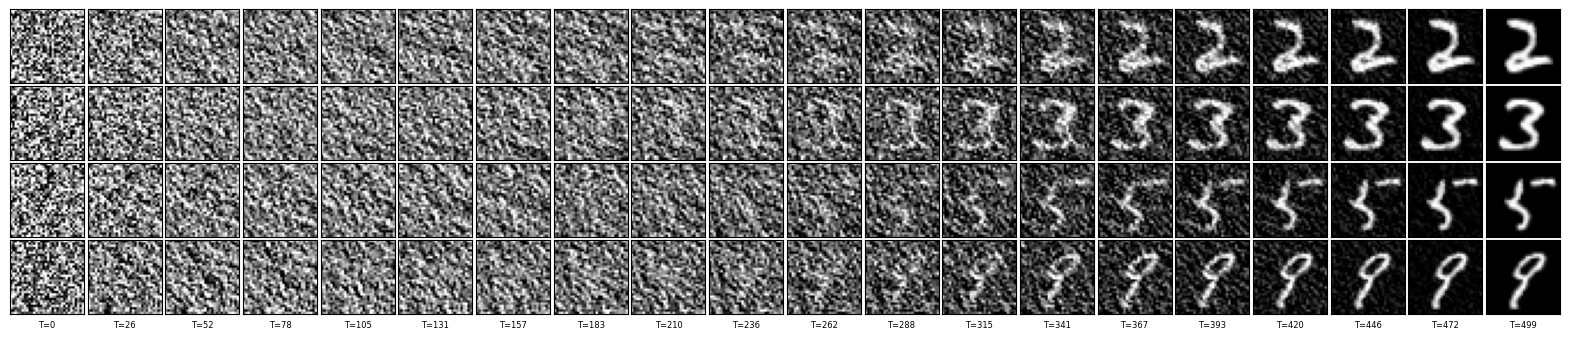

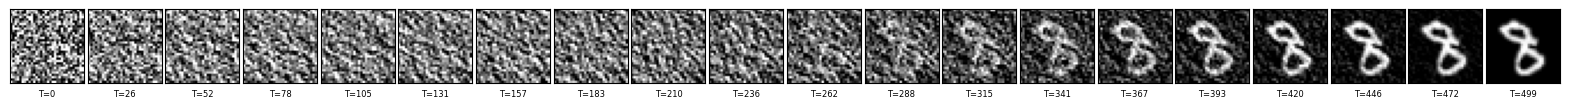

In [ ]:
visualize_reverse_trajectory_multi_labels(labels=[2, 3, 5, 9], vis_steps=20)
visualize_reverse_trajectory_multi_labels(labels=[8], vis_steps=20)

Loss curve

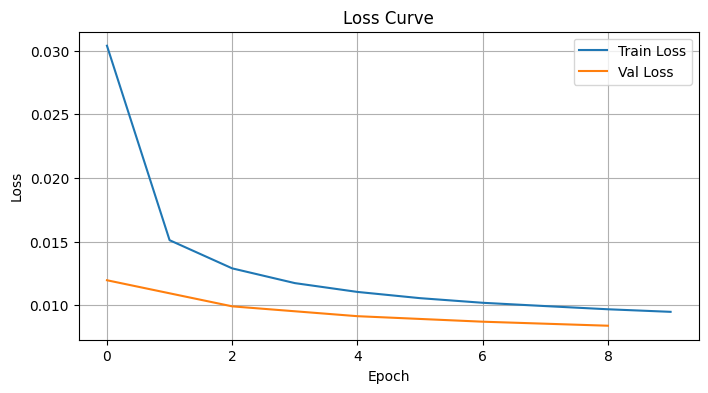

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label='Train Loss')
plt.plot([i for i in range(0, NUM_EPOCHS, 2)], val_loss_list, label='Val Loss')  # every 2 epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png", dpi=200, bbox_inches='tight')
plt.show()
